In [ ]:
import numpy as np
from scipy.signal import cont2discrete
import math

# Parameters
m = 0.08939794594871456        # Mass of pendulum (kg)
lp = 0.06          # Distance to pendulum center of mass (m)
g = 9.80665           # Gravity (m/s^2)
J_theta = 0.002830449  # Rotary arm moment of inertia (kg·m^2)
J_alpha = 0.000358709  # Pendulum arm moment of inertia (kg·m^2)
Ts = 0.05          # Sampling time (s)

# Continuous-time state-space matrices
A = np.array([
    [0, 1, 0, 0],
    [0, 0, m * lp**2 * g / J_theta, 0],
    [0, 0, 0, 1],
    [0, 0, -m * g * lp / J_alpha, 0]
])
B = np.array([
    [0],
    [1 / J_theta],
    [0],
    [0]
])

# Discretize the system
system_discrete = cont2discrete((A, B, np.eye(4), np.zeros((4, 1))), Ts, method='zoh')
Ad, Bd, _, _, _ = system_discrete

# Print results
print("Ad (Discrete-time A matrix):\n", Ad)
print("Bd (Discrete-time B matrix):\n", Bd)


Ad (Discrete-time A matrix):
 [[ 1.00000000e+00  5.00000000e-02  1.09556044e-02  1.82876656e-04]
 [ 0.00000000e+00  1.00000000e+00  4.36526184e-01  1.09556044e-02]
 [ 0.00000000e+00  0.00000000e+00  9.76859538e-01  4.96137273e-02]
 [ 0.00000000e+00  0.00000000e+00 -9.22031987e-01  9.76859538e-01]]
Bd (Discrete-time B matrix):
 [[  3.48471881]
 [139.38875244]
 [  0.        ]
 [  0.        ]]


In [ ]:
f_natural = (1 / (2 * math.pi)) * math.sqrt((m * g * lp) / J_alpha)
# print(f_natural)
print("Ts must be less than", 1/(10*f_natural), "seconds but greater than time to solve optimization problem")

1.9272973673670426
Ts must be less than 0.05188612909102552 seconds but greater than time to solve optimization problem


In [16]:
Np = 20  # Prediction horizon (number of steps to predict into the future)


# Define weight matrices
Q = np.diag([10, 1, 100, 1])  # Penalize pendulum angle and rotary arm angle more heavily
R = np.array([[0.1]])         # Penalize control effort


x_min = np.array([-np.pi, -10, -np.pi/6, -10])  # Example: Limits for [theta, theta_dot, alpha, alpha_dot]
x_max = np.array([np.pi, 10, np.pi/6, 10])      # Pendulum angles and velocities

u_min = np.array([-5])  # Minimum torque (Nm)
u_max = np.array([5])   # Maximum torque (Nm)


def build_mpc_matrices(Ad, Bd, Np):
    n, m = Bd.shape
    F = np.zeros((Np * n, n))
    G = np.zeros((Np * n, Np * m))

    for i in range(Np):
        F[i*n:(i+1)*n, :] = np.linalg.matrix_power(Ad, i+1)
        for j in range(i+1):
            G[i*n:(i+1)*n, j*m:(j+1)*m] = np.linalg.matrix_power(Ad, i-j) @ Bd

    return F, G

F, G = build_mpc_matrices(Ad, Bd, Np)



In [19]:
import cvxpy as cp

# Define optimization variables
U = cp.Variable((Np, 1))  # Control inputs
X_ref = np.zeros((Np * 4, 1))  # Reference trajectory (e.g., stabilize at zero)

x0 = np.array([0, 0, 0.1, 0]) 

# Predicted states
X_pred = F @ x0[:, np.newaxis] + G @ U

# Cost function
state_error = X_pred - X_ref
cost = cp.quad_form(state_error, np.kron(np.eye(Np), Q)) + cp.quad_form(U, np.kron(np.eye(Np), R))

# Constraints
constraints = []
for k in range(Np):
    constraints += [
        X_pred[k*4:(k+1)*4] <= x_max,
        X_pred[k*4:(k+1)*4] >= x_min,
    ]
    if k < Np:
        constraints += [U[k] <= u_max, U[k] >= u_min]

# Solve the optimization problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve()

# Optimal control inputs
u_optimal = U.value


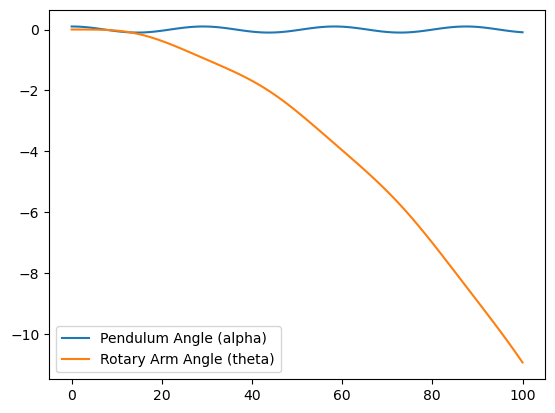

In [20]:
import matplotlib.pyplot as plt

# Simulation parameters
num_steps = 100
x_history = [x0]
u_history = []

# Run simulation
for t in range(num_steps):
    # Solve MPC
    problem.solve()
    u_optimal = U.value
    
    # Apply the first control input
    u0 = u_optimal[0]
    u_history.append(u0)
    
    # Update state
    x0 = Ad @ x0 + Bd @ u0
    x_history.append(x0)

# Plot results
x_history = np.array(x_history)
plt.figure()
plt.plot(x_history[:, 2], label="Pendulum Angle (alpha)")
plt.plot(x_history[:, 0], label="Rotary Arm Angle (theta)")
plt.legend()
plt.show()
